# **Cross-Validation Training on Dataset 02 for Binary SQL Injection Detection**

**We implements a comparative analysis of machine learning models (Naive Bayes, Random Forest, and Support Vector class) for SQL injection detection. The framework uses TF-IDF vectorization with n-grams on balanced datasets and optimizes hyperparameters via 5-fold cross-validation. While all models achieve high CV F1 scores (>0.99) during training, test set performance ranges from 48.6-52.25% accuracy when applying SQL-trained models to NoSQL data, highlighting domain transfer challenges. SVC with linear kernel performs best (52.25% accuracy, 0.65 F1-score for malicious queries), demonstrating potential for cross-domain vulnerability detection despite the significant shift between SQL and NoSQL contexts.**

# **Unzip Dataset Archive**

In [ ]:
!unzip /content/archive.zip -d /content/

Archive:  /content/archive.zip
  inflating: /content/sql_injectiondataset_final_updated.csv  


# **Import the Dataset**

In [ ]:
import pandas as pd
import json

# Load the JSON file
json_path = "/content/No-SqlDataset.json"
with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Convert JSON to DataFrame
df = pd.DataFrame(data)
# Save to CSV
csv_path = "/content/No-SqlDataset_Updated.csv"
df.to_csv(csv_path, index=False)

print("CSV saved to:", csv_path)


CSV saved to: /content/No-SqlDataset_Updated.csv


### 📊 Dataset Overview

- **Training Dataset**:Custom SQL Injection Dataset  
  - Total Samples: **3204**
  - Class Distribution:
    - SQL Injection (Malicious): **1602**
    - Normal (Non-Malicious): **1602**

- **Testing Dataset**:[SQL Injection Dataset](https://github.com/capnmav77/No-SQL_Gen/tree/master)
  - Total Samples: **356**
  - Class Distribution:
    - SQL Injection (Malicious): **178**
    - Normal (Non-Malicious): **178**

# **Naive Bayes**

/tmp/ipython-input-3267062828.py:12: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/content/sql_injectiondataset_final_updated.csv")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CV F1 Score: 1.0
Best Parameters: {'clf__alpha': 0.01, 'clf__fit_prior': True}
Test Accuracy: 0.5000
Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.0843    0.1442       178
           1     0.5000    0.9157    0.6468       178

    accuracy                         0.5000       356
   macro avg     0.5000    0.5000    0.3955       356
weighted avg     0.5000    0.5000    0.3955       356

Confusion Matrix:
 [[ 15 163]
 [ 15 163]]


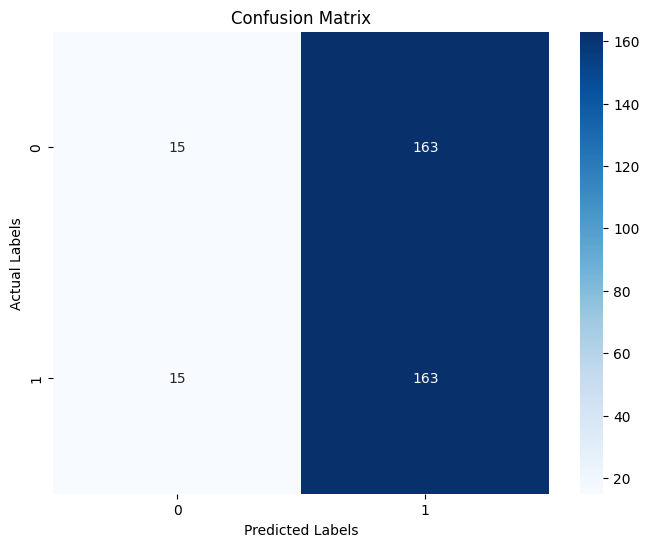

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load datasets (swapped)
df_train = pd.read_csv("/content/sql_injectiondataset_final_updated.csv")
df_test = pd.read_csv("/content/No-SqlDataset_Updated.csv")

# 2. Drop missing values
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['text', 'label'], inplace=True)

# 3. Rename columns to a common scheme
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'text': 'text', 'label': 'label'}, inplace=True)

# 4. Map labels to 0/1
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

# 5. Sample exactly 3204 train samples (1602 per class) and 356 test samples (178) per class)
df_train_0 = df_train[df_train.label == 0].sample(1602, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(1602, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(178, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(178, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Split into features and labels
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test = df_test_bal['text'], df_test_bal['label']

# 7. Build a pipeline: TF-IDF → Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20_000)),
    ('clf', MultinomialNB())
])

# 8. Hyperparameter grid for Naive Bayes
param_grid = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'clf__fit_prior': [True, False]
}

# 9. Cross‐validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Output best CV score and parameters
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate on the balanced test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 14. Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

## **Random Forest**

/tmp/ipython-input-2751860121.py:12: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/content/sql_injectiondataset_final_updated.csv")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best CV F1 Score: 0.9990465551537957
Best Parameters: {'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Test Accuracy: 0.4860
Classification Report:
               precision    recall  f1-score   support

           0     0.4747    0.2640    0.3394       178
           1     0.4903    0.7079    0.5793       178

    accuracy                         0.4860       356
   macro avg     0.4825    0.4860    0.4593       356
weighted avg     0.4825    0.4860    0.4593       356

Confusion Matrix:
 [[ 47 131]
 [ 52 126]]


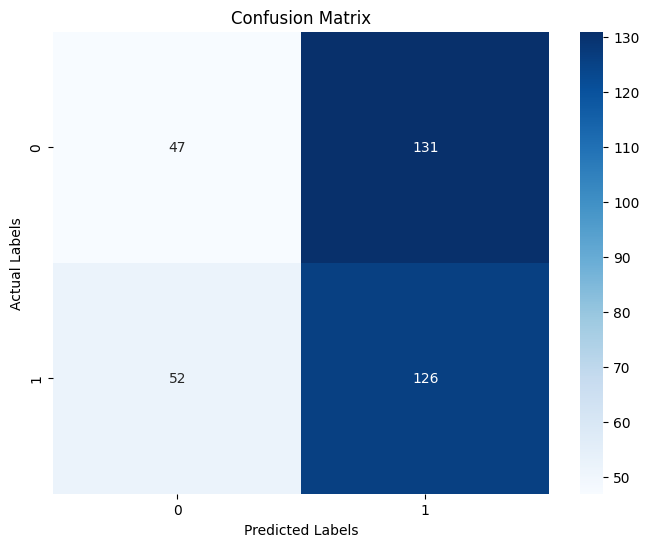

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load datasets (swapped)
df_train = pd.read_csv("/content/sql_injectiondataset_final_updated.csv")
df_test = pd.read_csv("/content/No-SqlDataset_Updated.csv")

# 2. Drop missing values
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['text', 'label'], inplace=True)

# 3. Rename columns to a common scheme
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'text': 'text', 'label': 'label'}, inplace=True)

# 4. Map labels to 0/1
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

#  5. Sample exactly 3204 train samples (1602 per class) and 356 test samples (178) per class
df_train_0 = df_train[df_train.label == 0].sample(1602, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(1602, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(178, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(178, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Split into features and labels
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test = df_test_bal['text'], df_test_bal['label']

# 7. Build a pipeline: TF-IDF → Random Forest
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20_000)),
    ('clf', RandomForestClassifier(random_state=42))
])

# 8. Hyperparameter grid for Random Forest
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# 9. Cross‐validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Output best CV score and parameters
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate on the balanced test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 14. Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

#**SVC**

/tmp/ipython-input-1869182062.py:12: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/content/sql_injectiondataset_final_updated.csv")


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best CV F1 Score: 1.0
Best Parameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Test Accuracy: 0.5225
Classification Report:
               precision    recall  f1-score   support

           0     0.5952    0.1404    0.2273       178
           1     0.5127    0.9045    0.6545       178

    accuracy                         0.5225       356
   macro avg     0.5540    0.5225    0.4409       356
weighted avg     0.5540    0.5225    0.4409       356

Confusion Matrix:
 [[ 25 153]
 [ 17 161]]


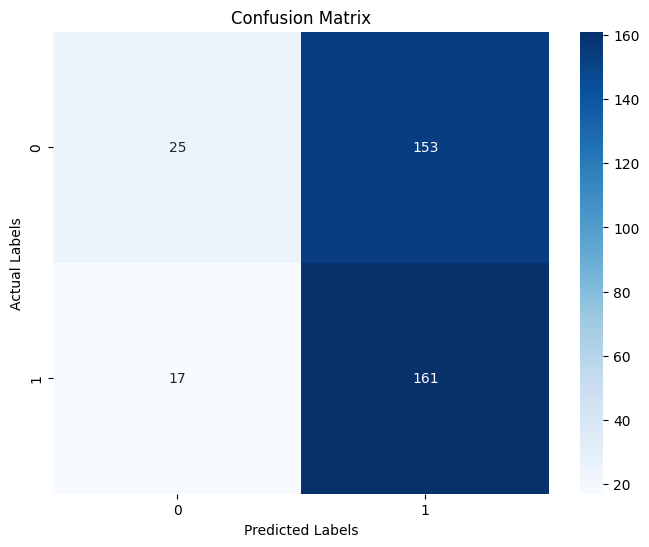

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load datasets (swapped)
df_train = pd.read_csv("/content/sql_injectiondataset_final_updated.csv")
df_test = pd.read_csv("/content/No-SqlDataset_Updated.csv")

# 2. Drop missing values
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['text', 'label'], inplace=True)

# 3. Rename columns to a common scheme
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'text': 'text', 'label': 'label'}, inplace=True)

# 4. Map labels to 0/1
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

# 5. Sample exactly 178 train samples (89 per class) and 178 test samples (89 per class)
df_train_0 = df_train[df_train.label == 0].sample(178, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(178, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(178, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(178, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Split into features and labels
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test = df_test_bal['text'], df_test_bal['label']

# 7. Build a pipeline: TF-IDF → SVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10_000)),
    ('clf', SVC(random_state=42))
])

# 8. Hyperparameter grid for SVC
param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__gamma': ['scale', 'auto', 0.1, 0.01],
    'clf__class_weight': [None, 'balanced'],
}

# 9. Cross‐validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Output best CV score and parameters
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate on the balanced test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 14. Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()